# Hospital Stay Days Prediction - Manoj Kumar

In [2]:
!pip install gradio
!pip install shap
!pip install lightgbm


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# imports 
import pandas as pd
import gradio as gr 
import numpy as np
import matplotlib.pyplot as plt
import shap
# from lightgbm import LGBMRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

In [4]:
# read in dataset
df = pd.read_csv("LengthOfStay.csv")
# Convert '5+' to 5.5
df['rcount'] = df['rcount'].replace('5+', 5.5)

# Convert the 'rcount' column to float
df['rcount'] = df['rcount'].astype(float)

df['gender'] = df['gender'].map({'F': 0, 'M': 1})
facid_mapping = {
    'A': 1,
    'B': 2,
    'C': 3,
    'D': 4,
    'E': 5
}

# Apply the mapping to the facid column
df['facid'] = df['facid'].map(facid_mapping)
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0.0,0,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,2,3
1,2,5/26/2012,5.5,0,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,1,7
2,3,9/22/2012,1.0,0,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,2,3
3,4,8/9/2012,0.0,0,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,1,1
4,5,12/20/2012,0.0,0,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,5,4


In [5]:
df

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0.0,0,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,2,3
1,2,5/26/2012,5.5,0,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,1,7
2,3,9/22/2012,1.0,0,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,2,3
3,4,8/9/2012,0.0,0,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,1,1
4,5,12/20/2012,0.0,0,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,5,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,1/28/2012,3.0,1,0,0,0,0,0,0,...,171.422555,12.0,0.650323,30.063069,80,6.5,1,2/3/2012,2,6
99996,99997,8/6/2012,0.0,1,0,0,0,0,0,0,...,122.342450,12.0,1.521424,28.969548,61,6.5,1,8/7/2012,2,1
99997,99998,7/23/2012,1.0,1,0,0,1,0,0,0,...,108.288106,12.0,1.025677,26.354919,61,6.9,1,7/27/2012,3,4
99998,99999,12/19/2012,0.0,1,0,0,0,0,0,0,...,111.750731,16.0,1.035400,29.193462,59,5.6,1,12/23/2012,2,4


In [6]:
# Check for null values
if df.isnull().any().any():
    print("DataFrame contains null values.")
else:
    print("DataFrame does not contain any null values.")


DataFrame does not contain any null values.


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   eid                         100000 non-null  int64  
 1   vdate                       100000 non-null  object 
 2   rcount                      100000 non-null  float64
 3   gender                      100000 non-null  int64  
 4   dialysisrenalendstage       100000 non-null  int64  
 5   asthma                      100000 non-null  int64  
 6   irondef                     100000 non-null  int64  
 7   pneum                       100000 non-null  int64  
 8   substancedependence         100000 non-null  int64  
 9   psychologicaldisordermajor  100000 non-null  int64  
 10  depress                     100000 non-null  int64  
 11  psychother                  100000 non-null  int64  
 12  fibrosisandother            100000 non-null  int64  
 13  malnutrition   

In [8]:
for col in df.columns: 
    display(df[col].value_counts())

eid
1         1
66651     1
66673     1
66672     1
66671     1
         ..
33332     1
33331     1
33330     1
33329     1
100000    1
Name: count, Length: 100000, dtype: int64

vdate
10/3/2012     333
6/14/2012     324
11/11/2012    324
9/27/2012     317
2/22/2012     315
             ... 
1/11/2012     230
7/6/2012      229
4/11/2012     227
12/1/2012     214
3/20/2012     212
Name: count, Length: 367, dtype: int64

rcount
0.0    55031
1.0    15007
2.0     9987
3.0     8047
4.0     6941
5.5     4987
Name: count, dtype: int64

gender
0    57643
1    42357
Name: count, dtype: int64

dialysisrenalendstage
0    96358
1     3642
Name: count, dtype: int64

asthma
0    96473
1     3527
Name: count, dtype: int64

irondef
0    90506
1     9494
Name: count, dtype: int64

pneum
0    96055
1     3945
Name: count, dtype: int64

substancedependence
0    93694
1     6306
Name: count, dtype: int64

psychologicaldisordermajor
0    76096
1    23904
Name: count, dtype: int64

depress
0    94834
1     5166
Name: count, dtype: int64

psychother
0    95061
1     4939
Name: count, dtype: int64

fibrosisandother
0    99521
1      479
Name: count, dtype: int64

malnutrition
0    95052
1     4948
Name: count, dtype: int64

hemo
0    92000
1     8000
Name: count, dtype: int64

hematocrit
11.900000    20179
12.000000     4866
11.600000     1550
11.800000     1516
12.100000     1509
             ...  
10.466667        3
6.750000         3
7.866667         3
11.033333        3
12.533333        2
Name: count, Length: 362, dtype: int64

neutrophils
9.400000     19719
9.300000      4248
6.900000       912
7.300000       872
8.100000       871
             ...  
20.833333        2
38.000000        2
10.533333        2
37.900000        2
3.066667         2
Name: count, Length: 656, dtype: int64

sodium
136.210150    2
141.642479    2
136.556976    2
138.311247    2
134.454042    2
             ..
138.991515    1
138.960912    1
136.767861    1
135.010558    1
140.950137    1
Name: count, Length: 99948, dtype: int64

glucose
148.470465    2
129.720211    2
192.476918    1
101.901810    1
127.227144    1
             ..
126.497136    1
134.358082    1
134.633990    1
153.441931    1
149.572205    1
Name: count, Length: 99998, dtype: int64

bloodureanitro
12.000000     45404
9.000000       4120
10.000000      3913
11.000000      3722
13.000000      3469
              ...  
62.500000         3
103.000000        3
41.500000         3
6.142857          3
474.000000        2
Name: count, Length: 261, dtype: int64

creatinine
1.187913    2
0.927038    2
1.211433    2
1.142182    2
0.896881    2
           ..
1.210521    1
1.302881    1
0.993664    1
1.261767    1
0.813004    1
Name: count, Length: 99994, dtype: int64

bmi
27.843315    2
28.844062    2
28.618775    2
30.322514    2
29.184922    2
            ..
29.859199    1
30.567566    1
30.002190    1
31.014736    1
25.175760    1
Name: count, Length: 99994, dtype: int64

pulse
71     3480
73     3384
72     3373
75     3371
74     3366
       ... 
126       1
25        1
23        1
130       1
120       1
Name: count, Length: 100, dtype: int64

respiration
6.500000    64833
6.400000     1524
6.200000     1498
6.600000     1473
6.900000     1449
            ...  
2.800000        3
1.600000        3
5.575000        2
6.166667        2
5.933333        2
Name: count, Length: 160, dtype: int64

secondarydiagnosisnonicd9
1     50029
0     10090
2      9782
3      9020
4      8990
5      3987
6      3086
7      1960
10     1049
8      1006
9      1001
Name: count, dtype: int64

discharged
2/16/2012     316
6/19/2012     315
10/25/2012    315
3/9/2012      313
10/28/2012    312
             ... 
1/9/2013       23
1/10/2013       7
1/12/2013       2
1/11/2013       2
1/13/2013       1
Name: count, Length: 378, dtype: int64

facid
5    30755
1    30035
2    30012
3     4699
4     4499
Name: count, dtype: int64

lengthofstay
1     17979
3     16068
4     14822
2     12825
5     12116
6     10362
7      7263
8      4652
9      2184
10     1000
11      460
12      137
13       75
14       31
15       16
16        6
17        4
Name: count, dtype: int64

In [9]:
# type conversions 
cat_cols = ["gender", "facid"]
bin_cols = ["dialysisrenalendstage", 
            "asthma", 
            "irondef", 
            "pneum", 
            "substancedependence", 
            "psychologicaldisordermajor",
            "depress",
            "psychother",
            "fibrosisandother",
            "malnutrition",
            "hemo"]
num_cols = ["hematocrit",
            "neutrophils",
            "sodium",
            "glucose",
            "bloodureanitro",
            "creatinine",
            "bmi",
            "respiration"]

for cat_col in cat_cols: 
    df[cat_col] = df[cat_col].astype("category")

In [10]:
df.head()

,eid,vdate,rcount,gender,dialysisrenalendstage,asthma,irondef,pneum,substancedependence,psychologicaldisordermajor,...,glucose,bloodureanitro,creatinine,bmi,pulse,respiration,secondarydiagnosisnonicd9,discharged,facid,lengthofstay
0,1,8/29/2012,0.0,0,0,0,0,0,0,0,...,192.476918,12.0,1.390722,30.432418,96,6.5,4,9/1/2012,2,3
1,2,5/26/2012,5.5,0,0,0,0,0,0,0,...,94.078507,8.0,0.943164,28.460516,61,6.5,1,6/2/2012,1,7
2,3,9/22/2012,1.0,0,0,0,0,0,0,0,...,130.530524,12.0,1.065750,28.843812,64,6.5,2,9/25/2012,2,3
3,4,8/9/2012,0.0,0,0,0,0,0,0,0,...,163.377028,12.0,0.906862,27.959007,76,6.5,1,8/10/2012,1,1
4,5,12/20/2012,0.0,0,0,0,0,1,0,1,...,94.886654,11.5,1.242854,30.258927,67,5.6,2,12/24/2012,5,4


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 28 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   eid                         100000 non-null  int64   
 1   vdate                       100000 non-null  object  
 2   rcount                      100000 non-null  float64 
 3   gender                      100000 non-null  category
 4   dialysisrenalendstage       100000 non-null  int64   
 5   asthma                      100000 non-null  int64   
 6   irondef                     100000 non-null  int64   
 7   pneum                       100000 non-null  int64   
 8   substancedependence         100000 non-null  int64   
 9   psychologicaldisordermajor  100000 non-null  int64   
 10  depress                     100000 non-null  int64   
 11  psychother                  100000 non-null  int64   
 12  fibrosisandother            100000 non-null  int64   
 13  

In [12]:
# number_of_issues transform function
def calculate_number_of_issues(df, bin_cols):
    df["numberofissues"] = df[bin_cols].sum(axis=1)
    return df

df = calculate_number_of_issues(df, bin_cols)

In [13]:

df.isnull().sum()
labels, features = df[["lengthofstay"]], df.drop(["lengthofstay", "discharged", "vdate", "eid"], axis=1)
labels.value_counts()

lengthofstay
1               17979
3               16068
4               14822
2               12825
5               12116
6               10362
7                7263
8                4652
9                2184
10               1000
11                460
12                137
13                 75
14                 31
15                 16
16                  6
17                  4
Name: count, dtype: int64

In [14]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 25 columns):
 #   Column                      Non-Null Count   Dtype   
---  ------                      --------------   -----   
 0   rcount                      100000 non-null  float64 
 1   gender                      100000 non-null  category
 2   dialysisrenalendstage       100000 non-null  int64   
 3   asthma                      100000 non-null  int64   
 4   irondef                     100000 non-null  int64   
 5   pneum                       100000 non-null  int64   
 6   substancedependence         100000 non-null  int64   
 7   psychologicaldisordermajor  100000 non-null  int64   
 8   depress                     100000 non-null  int64   
 9   psychother                  100000 non-null  int64   
 10  fibrosisandother            100000 non-null  int64   
 11  malnutrition                100000 non-null  int64   
 12  hemo                        100000 non-null  int64   
 13  

In [15]:
x_train, x_test, y_train, y_test = train_test_split(features, labels)

In [16]:
!pip install --force-reinstall graphviz==0.18

  Using cached graphviz-0.18-py3-none-any.whl.metadata (10 kB)
Using cached graphviz-0.18-py3-none-any.whl (38 kB)
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.18
    Uninstalling graphviz-0.18:
      Successfully uninstalled graphviz-0.18



[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(features, labels)

# Create a Random Forest Regressor model
forest_regressor = RandomForestRegressor(random_state=42)

# Train the model using the training sets
forest_regressor.fit(x_train, y_train)

# Make predictions using the testing set
y_pred = forest_regressor.predict(x_test)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Root Mean Squared Error (RMSE)
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Print the metrics
print('Mean Squared Error (MSE):', mse)
print('R-squared (R2) score:', r2)
print('Mean Absolute Error (MAE):', mae)
print('Root Mean Squared Error (RMSE):', rmse)


C:\Users\nagam\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1152: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error (MSE): 0.341587168
R-squared (R2) score: 0.9386669158861862
Mean Absolute Error (MAE): 0.33783119999999994
Root Mean Squared Error (RMSE): 0.5844545901949953


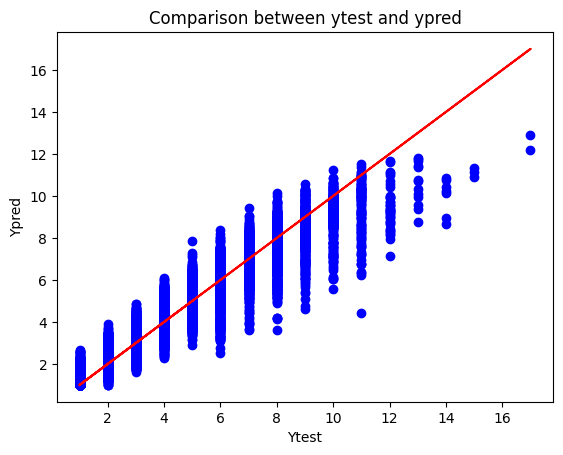

In [18]:
# Plotting
plt.scatter(y_test, y_pred, color='blue')  # Scatter plot with red color
plt.plot(y_test, y_test, color='red')     # Line plot with blue color (y = x line)

# Adding labels and title
plt.xlabel('Ytest')
plt.ylabel('Ypred')
plt.title('Comparison between ytest and ypred')

# Displaying the plot
plt.show()